# Short-term electricity load forecasting (Panama case study) using LSTM networks

Source: https://data.mendeley.com/datasets/byx7sztj59/1

Downloads and preproceses the data. Then, trains an LSTM model from Neuromancer blocks and plots the forecast.


### Import statements


In [1]:

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset

### Set numpy and torch seeds for reproducibility, and choose device automatically


In [2]:
torch.manual_seed(0)
np.random.seed(0)

# Device configuration
if torch.backends.mps.is_available():
    device = torch.device('mps')
elif torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

print(f"Using device: {device}")

Using device: cuda


### Download data set

Short-term electricity load forecasting (Panama case study) from Mendeley Data 

(DOI:10.17632/byx7sztj59.1)


In [3]:
url = "https://data.mendeley.com/public-files/datasets/byx7sztj59/files/94ef3285-7ce4-43e2-9fd3-9cb3f592b89c/file_downloaded"
response = requests.get(url, stream=True)

file_name = "continuous_dataset.csv"
with open(file_name, "wb") as file:
    file.write(response.content)
    

### Read csv file as Pandas dataframe and set index


In [4]:

df = pd.read_csv(file_name)
df = df.set_index("datetime")
df.index = pd.to_datetime(df.index)
df

,nat_demand,T2M_toc,QV2M_toc,TQL_toc,W2M_toc,T2M_san,QV2M_san,TQL_san,W2M_san,T2M_dav,QV2M_dav,TQL_dav,W2M_dav,Holiday_ID,holiday,school
datetime,,,,,,,,,,,,,,,,
2015-01-03 01:00:00,970.3450,25.865259,0.018576,0.016174,21.850546,23.482446,0.017272,0.001855,10.328949,22.662134,0.016562,0.096100,5.364148,0,0,0
2015-01-03 02:00:00,912.1755,25.899255,0.018653,0.016418,22.166944,23.399255,0.017265,0.001327,10.681517,22.578943,0.016509,0.087646,5.572471,0,0,0
2015-01-03 03:00:00,900.2688,25.937280,0.018768,0.015480,22.454911,23.343530,0.017211,0.001428,10.874924,22.531030,0.016479,0.078735,5.871184,0,0,0
2015-01-03 04:00:00,889.9538,25.957544,0.018890,0.016273,22.110481,23.238794,0.017128,0.002599,10.518620,22.512231,0.016487,0.068390,5.883621,0,0,0
2015-01-03 05:00:00,893.6865,25.973840,0.018981,0.017281,21.186089,23.075403,0.017059,0.001729,9.733589,22.481653,0.016456,0.064362,5.611724,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-06-26 20:00:00,1128.5592,27.246545,0.020303,0.055511,9.289304,25.715295,0.019746,0.121552,1.990773,23.746545,0.018381,0.150879,2.444658,0,0,1
2020-06-26 21:00:00,1112.7488,27.099573,0.020395,0.053848,9.837504,25.552698,0.019632,0.153870,2.094459,23.693323,0.018320,0.156311,2.515814,0,0,1
2020-06-26 22:00:00,1081.5680,26.971155,0.020448,0.057251,10.262464,25.393030,0.019518,0.144531,2.396369,23.658655,0.018327,0.153259,2.800717,0,0,1



### Drop uninformative features
#### Column descriptions (from https://data.mendeley.com/datasets/byx7sztj59/1/files/6952a984-f474-437f-8640-67d773caea93)
- nat_demand: National electricity load (Target or Dependent variable) (MWh)
- T2M_toc: Temperature at 2 meters in Tocumen, Panama city (ºC)
- QV2M_toc: Relative humidity at 2 meters in Tocumen, Panama city (%)
- TQL_toc: Liquid precipitation in Tocumen, Panama city liters/m2
- W2M_toc: Wind Speed at 2 meters in Tocumen, Panama city m/s
- T2M_san: Temperature at 2 meters in Santiago city ºC
- QV2M_san: Relative humidity at 2 meters in Santiago city %
- TQL_san: Liquid precipitation in Santiago city l/m2
- W2M_san: Wind Speed at 2 meters in Santiago city m/s
- T2M_dav: Temperature at 2 meters in David city ºC
- QV2M_dav: Relative humidity at 2 meters in David city %
- TQL_dav: Liquid precipitation in David city l/m2
- W2M_dav: Wind Speed at 2 meters in David city m/s
- Holiday_ID: Unique identification number integer
- holiday: Holiday binary indicator 1 = holiday, 0 = regular day
- school: School period binary indicator 1 = school, 0 = vacations


In [5]:

excluded_cols = ['Holiday_ID']
df = df.drop(columns=excluded_cols)
df.columns


Index(['nat_demand', 'T2M_toc', 'QV2M_toc', 'TQL_toc', 'W2M_toc', 'T2M_san',
       'QV2M_san', 'TQL_san', 'W2M_san', 'T2M_dav', 'QV2M_dav', 'TQL_dav',
       'W2M_dav', 'holiday', 'school'],
      dtype='object')

### Split the data into training, validation and test sets

In [6]:

seq_length = 72 # lookback = 72 hours
train_split = 0.7
val_split = 0.15
test_split = 1 - (train_split + val_split)

train_size = int(train_split * len(df))
val_size = int(val_split * len(df))

# Train set
df_train = df[:train_size]

# Val set
val_start = train_size + seq_length
val_end = val_start + val_size
df_val = df[val_start:val_end] # add gap between train and test datasets to prevent data leakage:]

# Test set
df_test = df[val_end+seq_length:] # add gap between train and test datasets to prevent data leakage:]

### Fit scaler to train data and scale train data

In [7]:

scaler = MinMaxScaler(feature_range=(-1,1))
train_data = scaler.fit_transform(df_train)
train_data.min(), train_data.max()

(-1.0, 1.0000000000000002)

### Transform val and test data using the scaler parameters for train data

In [8]:
val_data = scaler.transform(df_val)
test_data = scaler.transform(df_test)

### Create sequential data with a arbitrary window size

In [9]:
def create_timeseries(data, len_sequence):
    X, y = [], []
    for i in range(len(data) - len_sequence):
        X.append(data[i:i+len_sequence])
        y.append(data[i+len_sequence][0]) # columm 0 is the load

    X, y = np.array(X), np.array(y).reshape(-1,1)
    return X, y

X_train, y_train = create_timeseries(train_data, seq_length)
X_val, y_val = create_timeseries(val_data, seq_length)
X_test, y_test = create_timeseries(test_data, seq_length)

### Create a custom dataset class for PyTorch DataLoader

In [10]:
from neuromancer.dataset import default_collate


class PanamaLoadDataset(Dataset):
    def __init__(self, X, y, type="Train"):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)
        self.name = type.lower()

    def __len__(self):
        return len(self.X)

    def collate_fn(self, batch):
        """Wraps the default PyTorch batch collation function and adds a name field.

        :param batch: (dict str: torch.Tensor) dataset sample.
        """
        batch = default_collate(batch)
        batch['name'] = self.name
        return batch

    def __getitem__(self, index):
        
        if self.name == 'test':
            return {
                'X': self.X[index],
                'Y': self.y[index],
                'name': self.name
            }
        else:
            return {
                'X': self.X[index],
                'Y': self.y[index]
            }


### Set experiment hyperparameters and train, val, test data sets

In [11]:
# Hyperparameters
input_size = X_train.shape[2]
hidden_size = 64
num_layers = 2
output_size = 1
learning_rate = 0.00001
num_epochs = 100
batch_size = 64

# Create data loaders
train_dataset = PanamaLoadDataset(X_train, y_train, type="Train")
train_loader = DataLoader(train_dataset, batch_size=batch_size, collate_fn = train_dataset.collate_fn, shuffle=False)

val_dataset = PanamaLoadDataset(X_val, y_val, type="Dev")
val_loader = DataLoader(val_dataset, batch_size=batch_size, collate_fn = val_dataset.collate_fn, shuffle=False)

test_dataset = PanamaLoadDataset(X_test, y_test, type="Test")
test_loader = DataLoader(test_dataset, batch_size=batch_size, collate_fn = test_dataset.collate_fn, shuffle=False)

### Initialize the neural network from Neuromancer blocks

In [12]:
from neuromancer.modules import blocks


block_lstm = blocks.PytorchLSTM(
    insize=input_size, 
    outsize=output_size, 
    hsizes=[hidden_size] * num_layers,
    num_layers=num_layers,
    linear_map=torch.nn.Linear, 
    nonlin=torch.nn.ReLU, 
)
block_lstm

PytorchLSTM(
  (lstm): LSTM(15, 64, num_layers=2)
  (output): Linear(in_features=64, out_features=1, bias=True)
)

### Use Neuromancer to define the Node, objective, constraints and problem

None


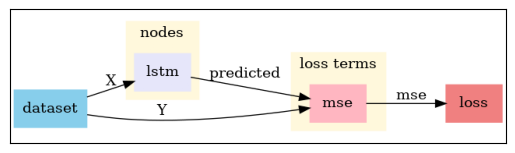

In [13]:
from neuromancer.system import Node
from neuromancer.trainer import Trainer
from neuromancer.problem import Problem
from neuromancer.loggers import BasicLogger
from neuromancer.constraint import variable
from neuromancer.loss import PenaltyLoss


model = block_lstm
model = model.to(device)

lstm_node = Node(model, ['X'],['predicted'], name = 'lstm')

nodes = [lstm_node]

predicted = variable('predicted')
real = variable('Y')

MSE = (real == predicted)^2 # Choose mean squared error as the loss function.
MSE.name='mse'

constraints = []
objectives = [MSE] 

# create constrained optimization loss
loss_ = PenaltyLoss(objectives, constraints)
# construct constrained optimization problem
problem = Problem(nodes, loss_)

optimizer = torch.optim.Adam(block_lstm.parameters(), lr=0.005) #we choose the Adam optimizer because it reports to have a faster convergence and little memory requirements

logger = BasicLogger(args=None, savedir='test', verbosity=1,
                        stdout=['dev_loss', 'train_loss'])

problem.show()

### Initiate Neuromancer Trainer, train the model and restore the best model weights.

In [14]:
N_EPOCHS = 100

problem = problem.to(device=device)

trainer = Trainer(
    problem,
    train_loader,
    val_loader,
    test_loader,
    optimizer,
    patience=5,
    warmup=30,
    epochs=N_EPOCHS,
    eval_metric="dev_loss",
    train_metric="train_loss",
    dev_metric="dev_loss",
    test_metric="dev_loss",
    logger=logger,
    device=device
)

best_model = trainer.train()
problem.load_state_dict(best_model)

Number of parameters: 54081
epoch: 0	train_loss: 0.00208	dev_loss: 0.00202	eltime:  1.02709
epoch: 1	train_loss: 0.00198	dev_loss: 0.00455	eltime:  1.80165
epoch: 2	train_loss: 0.00153	dev_loss: 0.00388	eltime:  2.56488
epoch: 3	train_loss: 0.00155	dev_loss: 0.00384	eltime:  3.31810
epoch: 4	train_loss: 0.00128	dev_loss: 0.00360	eltime:  4.10332
epoch: 5	train_loss: 0.00124	dev_loss: 0.00268	eltime:  4.88263
epoch: 6	train_loss: 0.00134	dev_loss: 0.00257	eltime:  5.63168
epoch: 7	train_loss: 0.00139	dev_loss: 0.00217	eltime:  6.40207
epoch: 8	train_loss: 0.00117	dev_loss: 0.00197	eltime:  7.18254
epoch: 9	train_loss: 0.00084	dev_loss: 0.00185	eltime:  7.95130
epoch: 10	train_loss: 0.00072	dev_loss: 0.00169	eltime:  8.70561
epoch: 11	train_loss: 0.00062	dev_loss: 0.00164	eltime:  9.46110
epoch: 12	train_loss: 0.00098	dev_loss: 0.00165	eltime:  10.21229
epoch: 13	train_loss: 0.00068	dev_loss: 0.00150	eltime:  10.96435
epoch: 14	train_loss: 0.00069	dev_loss: 0.00164	eltime:  11.72624
epoc

<All keys matched successfully>

### Test the model on test set, show performance metrics and plot forecasts

Testing on test set...
Root Mean Squared Error (RMSE): 31.182369314435928
Mean Absolute Error (MAE): 22.79
Mean Absolute Percentage Error (MAPE): 1.90%


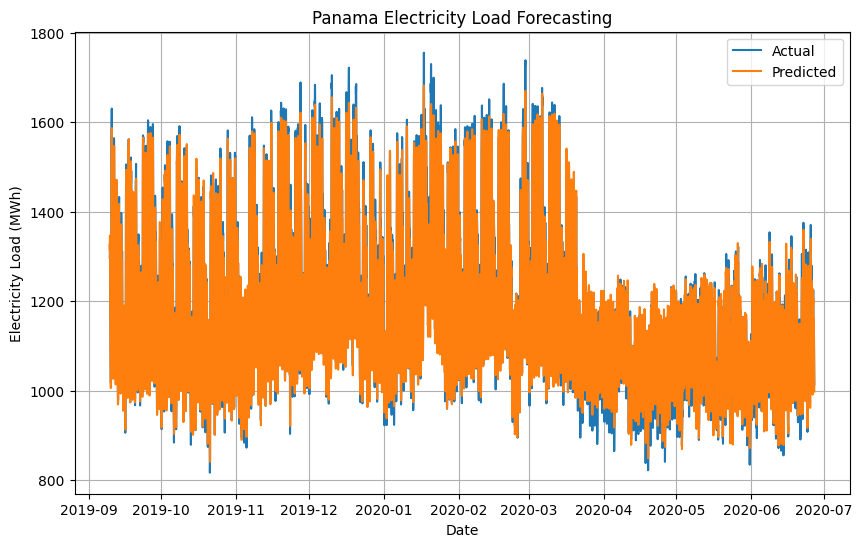

In [15]:
# Define a function to compute inverse transform of target variable only

def inverse_tranform_y(y_scaled):
    y = y_scaled - scaler.min_[0]
    y = y / scaler.scale_[0]
    return y

print("Testing on test set...")
with torch.no_grad():
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
    X_test_tensor = X_test_tensor.to(device)
    y_test_tensor = torch.tensor(y_test, dtype=torch.float32).to(device)

    y_pred = model(X_test_tensor)#.numpy()

    y_pred_scaled = inverse_tranform_y(y_pred.cpu())
    y_test_scaled = inverse_tranform_y(y_test)

    # Calculate RMSE
    mse = mean_squared_error(y_test_scaled, y_pred_scaled)
    rmse = np.sqrt(mse)
    print(f"Root Mean Squared Error (RMSE): {rmse}")
    mae = mean_absolute_error(y_test_scaled, y_pred_scaled)
    print(f"Mean Absolute Error (MAE): {mae:.2f}")
    mape = mean_absolute_percentage_error(y_test_scaled, y_pred_scaled) * 100
    print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")

# Visualize predictions against actual data
plt.figure(figsize=(10, 6))
plt.plot(df_test.index[seq_length:], y_test_scaled, label='Actual')
plt.plot(df_test.index[seq_length:], y_pred_scaled, label='Predicted')
plt.xlabel('Date')
plt.ylabel('Electricity Load (MWh)')
plt.title('Panama Electricity Load Forecasting')
plt.grid()
plt.legend()
plt.show()

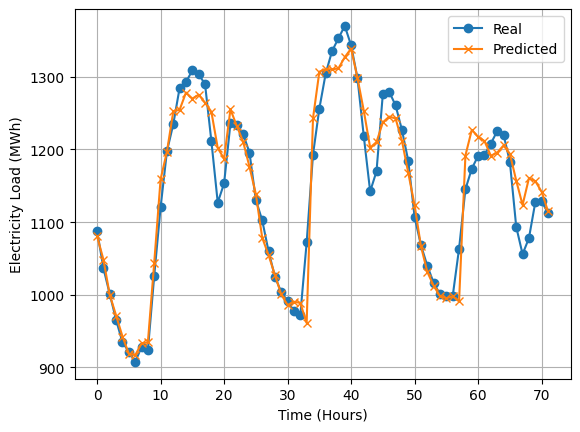

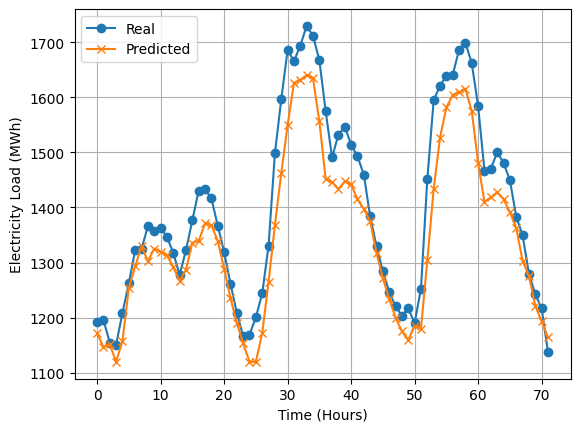

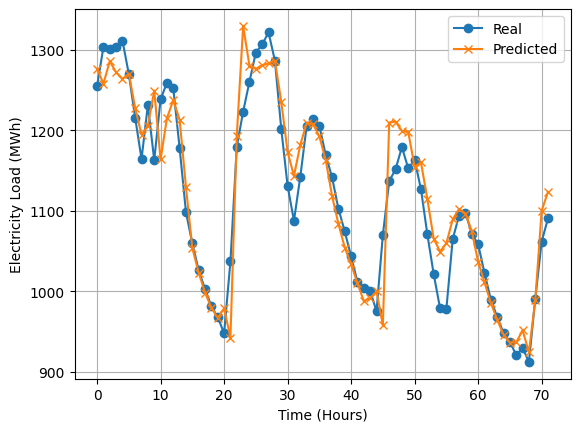

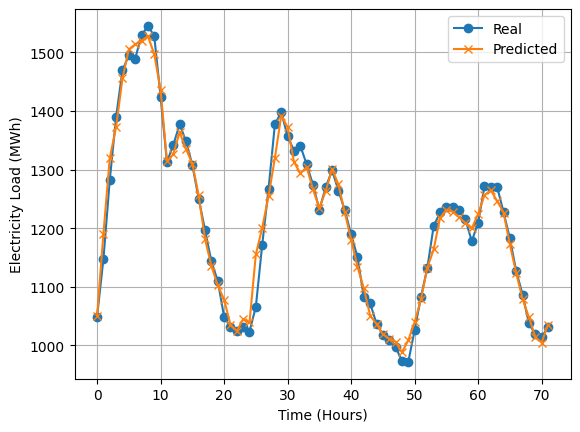

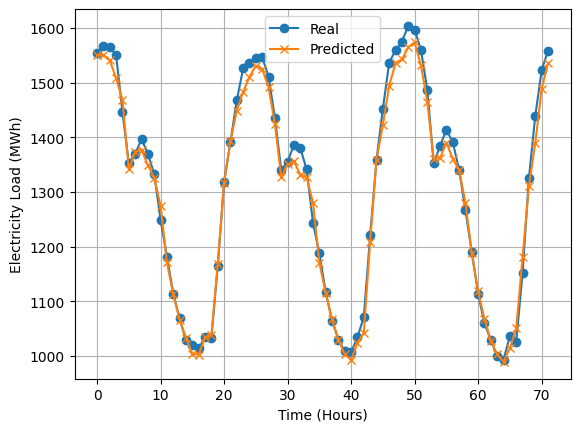

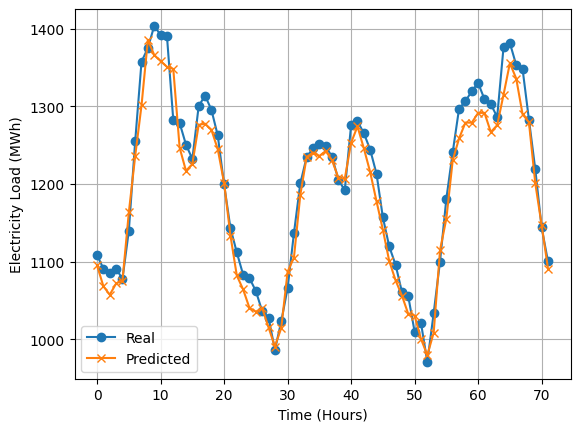

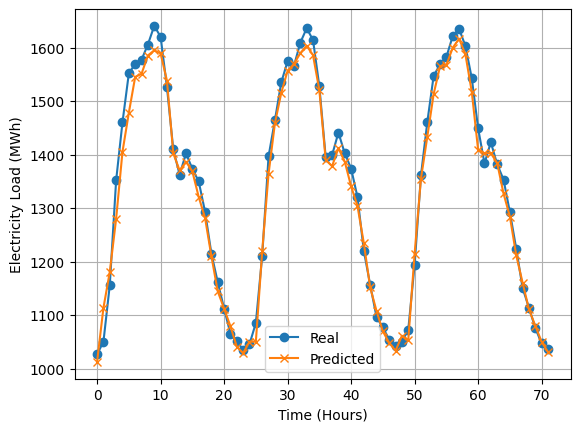

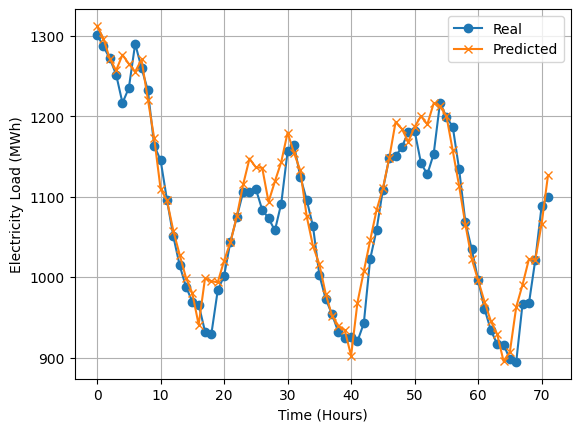

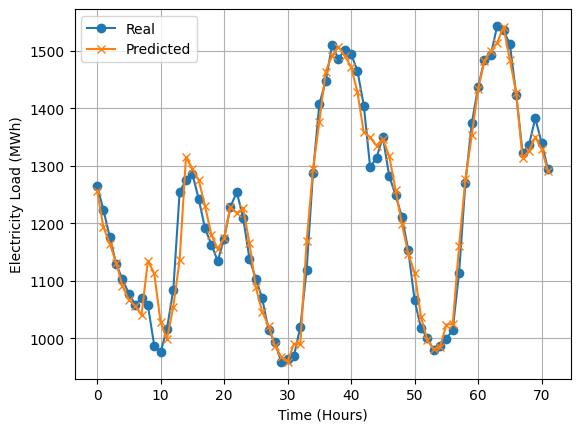

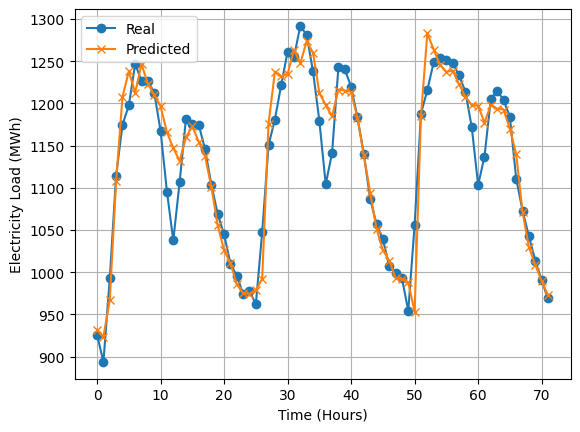

In [16]:
#%% Randomly choose 72-hour intervals to show forecasts

import random


random.seed(0)
num_samples = 10
forecast_window = 72

start_idxs = random.sample(range(len(y_pred_scaled)), num_samples)

for idx in start_idxs:

    plt.plot(y_test_scaled[idx:idx+forecast_window], label='Real', marker='o')
    plt.plot(y_pred_scaled[idx:idx+forecast_window], label='Predicted', marker='x')

    plt.ylabel('Electricity Load (MWh)')
    plt.xlabel('Time (Hours)')
    plt.grid()
    plt.legend()
    plt.show()

    